Download all necessary data

In [ ]:
!kaggle datasets download -d hasyimabdillah/workoutexercises-images
!unzip workoutexercises-images.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/pull up/pull up_700211.jpg  
  inflating: dataset/pull up/pull up_700221.jpg  
  inflating: dataset/pull up/pull up_700231.jpg  
  inflating: dataset/pull up/pull up_700241.jpg  
  inflating: dataset/pull up/pull up_700251.jpg  
  inflating: dataset/pull up/pull up_700261.jpg  
  inflating: dataset/pull up/pull up_800001.jpg  
  inflating: dataset/pull up/pull up_800011.jpg  
  inflating: dataset/pull up/pull up_800021.jpg  
  inflating: dataset/pull up/pull up_800031.jpg  
  inflating: dataset/pull up/pull up_800041.jpg  
  inflating: dataset/pull up/pull up_800051.jpg  
  inflating: dataset/pull up/pull up_800061.jpg  
  inflating: dataset/pull up/pull up_800071.jpg  
  inflating: dataset/pull up/pull up_800081.jpg  
  inflating: dataset/pull up/pull up_800091.jpg  
  inflating: dataset/pull up/pull up_800101.jpg  
  inflating: dataset/pull up/pull up_800111.jpg  
  inflating: dataset/pull up/pull up_800121.jpg  

Preprocessing Step

In [ ]:
!pip install imutils
!pip install requests
!pip install torch torchvision --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import shutil
from imutils import paths
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset paths
data_dir = Path("/content/dataset")  # Update to match dataset structure
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

# Ensure dataset directories exist
def check_directories():
    if not data_dir.exists():
        raise FileNotFoundError(f"Dataset directory {data_dir} not found. Ensure dataset is correctly placed.")

In [ ]:
# Define transformations
def get_transforms():
    return {
        "train": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

# Prepare dataset
def prepare_dataset():
    if not train_dir.exists():
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        image_paths = list(paths.list_images(data_dir))
        train_paths, rest_paths = train_test_split(image_paths, test_size=0.3, stratify=[Path(p).parent.name for p in image_paths], random_state=42)
        val_paths, test_paths = train_test_split(rest_paths, test_size=0.5, stratify=[Path(p).parent.name for p in rest_paths], random_state=42)

        for path_list, folder in zip([train_paths, val_paths, test_paths], [train_dir, val_dir, test_dir]):
            for img_path in path_list:
                label = Path(img_path).parent.name
                label_dir = folder / label
                label_dir.mkdir(parents=True, exist_ok=True)
                shutil.copy(img_path, label_dir / Path(img_path).name)


In [ ]:
# Load datasets
def load_datasets():
    transforms_dict = get_transforms()
    print(train_dir)
    return {
        "train": datasets.ImageFolder(train_dir, transform=transforms_dict["train"]),
        "val": datasets.ImageFolder(val_dir, transform=transforms_dict["val"]),
        "test": datasets.ImageFolder(test_dir, transform=transforms_dict["val"])
    }


In [ ]:
# Create DataLoaders
def get_dataloaders(datasets_dict):
    return {
        "train": DataLoader(datasets_dict["train"], batch_size=16, shuffle=True, num_workers=4),
        "val": DataLoader(datasets_dict["val"], batch_size=16, shuffle=False, num_workers=4),
        "test": DataLoader(datasets_dict["test"], batch_size=16, shuffle=False, num_workers=4)
    }

Preprocessing

In [ ]:
check_directories()
prepare_dataset()
datasets_dict = load_datasets()
dataloaders = get_dataloaders(datasets_dict)

/content/dataset/train


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Load EfficientNet model
def get_model():
    model = models.resnet50(pretrained=True)
    # num_ftrs = model.classifier[1].in_features
    num_ftrs = model.fc.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, len(os.listdir(train_dir))),
        nn.LogSoftmax(dim=1)
    )
    return model.to(device)

In [ ]:
# Train model
def train_model(model, criterion, optimizer, dataloaders, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloaders["train"]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / total

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in dataloaders["val"]:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet.pth")

In [ ]:
def classify_image_from_url(image_url, model):
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw).convert("RGB")
    transform = get_transforms()["val"]
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    class_names = sorted(os.listdir(train_dir))
    predicted_label = class_names[predicted_class]

    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label

Train Model

In [ ]:
model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
train_model(model, criterion, optimizer, dataloaders, epochs=5)
# model.load_state_dict(torch.load("best_efficientnet.pth", map_location=device))
# model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Epoch 1/5 | Train Loss: 0.8444 | Train Acc: 77.58% | Val Acc: 86.62%
Epoch 2/5 | Train Loss: 0.3357 | Train Acc: 90.53% | Val Acc: 90.33%
Epoch 3/5 | Train Loss: 0.2439 | Train Acc: 92.89% | Val Acc: 95.81%
Epoch 4/5 | Train Loss: 0.1962 | Train Acc: 94.61% | Val Acc: 94.23%
Epoch 5/5 | Train Loss: 0.1724 | Train Acc: 95.10% | Val Acc: 96.44%


Classifying on google Images

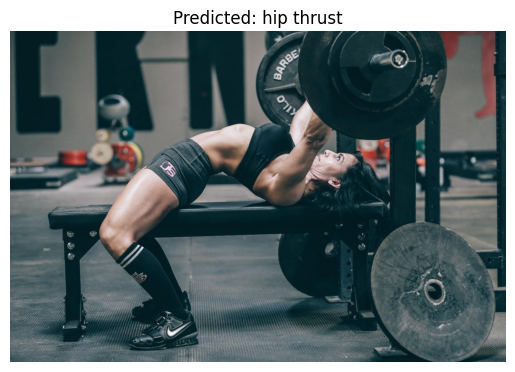

'hip thrust'

In [ ]:
image_url = 'https://i0.wp.com/womenwholiftweights.com/wp-content/uploads/2016/12/WomanBenchPress.jpg?fit=1518%2C1012&ssl=1'
classify_image_from_url(image_url, model)

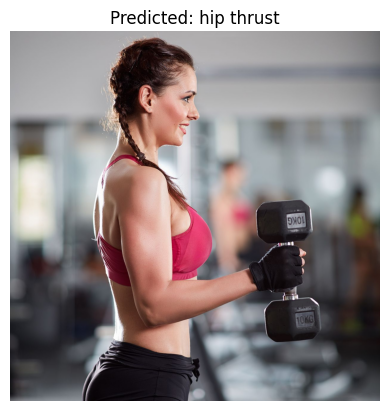

'hip thrust'

In [ ]:
image_url = 'https://www.shape.com/thmb/zM_afeI7D3spw4da9OqU4-KDGR0=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/hammer-curls-form-5c6c9cfb28f34c8e97cd64812156a9d1.jpg'
classify_image_from_url(image_url, model)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


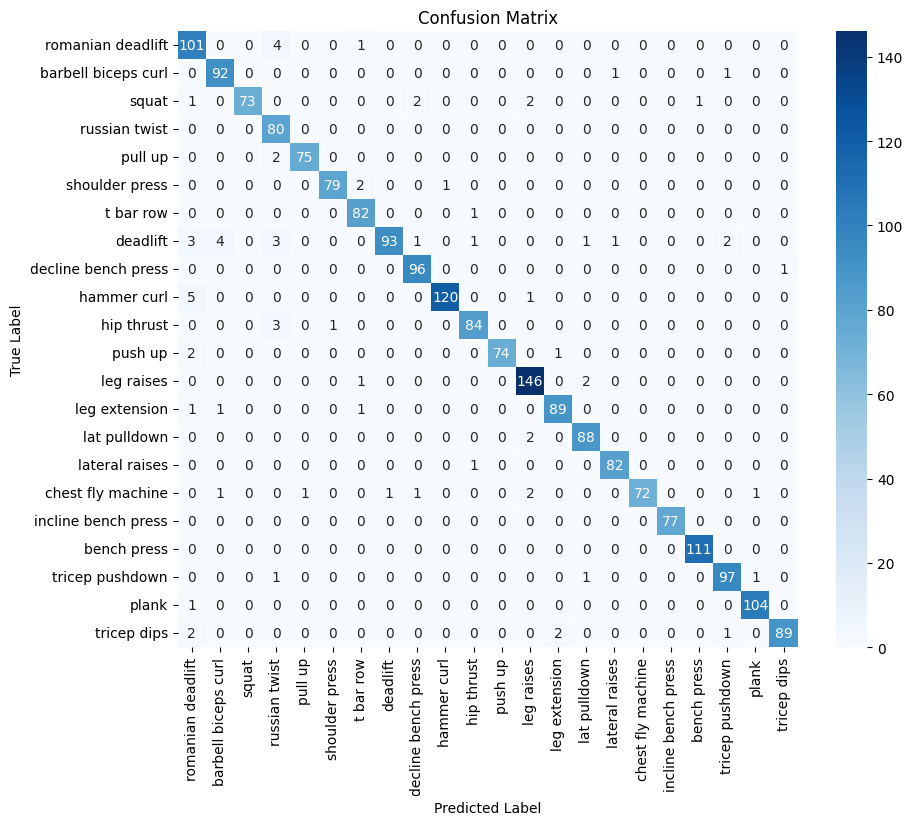

In [ ]:
evaluate_model(model, dataloaders['val'])

In [ ]:
import cv2
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
image_paths = list(paths.list_images('/content/dataset'))
hashes = {}

# loop over our image paths
for image_path in image_paths:
	# load the input image and compute the hash
	image = cv2.imread(image_path)
	h = dhash(image)

	# grab all image paths with that hash, add the current image
	# path to it, and store the list back in the hashes dictionary
	p = hashes.get(h, [])
	p.append(image_path)
	hashes[h] = p

[INFO] computing image hashes...


In [ ]:
import numpy as np
args = {
	"dataset": "/content/dataset",
	"remove": 1
}

# loop over the image hashes
for (h, hashed_paths) in hashes.items():
	# check to see if there is more than one image with the same hash
	if len(hashed_paths) > 1:
		# check to see if this is a dry run
		if args["remove"] <= 0:
			# initialize a montage to store all images with the same
			# hash
			montage = None

			# loop over all image paths with the same hash
			for p in hashed_paths:
				# load the input image and resize it to a fixed width
				# and heightG
				image = cv2.imread(p)
				image = cv2.resize(image, (150, 150))

				# if our montage is None, initialize it
				if montage is None:
					montage = image

				# otherwise, horizontally stack the images
				else:
					montage = np.hstack([montage, image])

			# show the montage for the hash
			print("[INFO] hash: {}".format(h))
			plt_imshow("Montage", montage)

        # otherwise, we'll be removing the duplicate images
		else:
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
			for p in hashed_paths[1:]:
				os.remove(p)

Pose Estimation

In [ ]:
!pip install mediapipe opencv-python

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial import procrustes

# Define dataset directory
dataset_dir = "/content/dataset"  # Change this if necessary

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

# Function to align poses using Procrustes Analysis
def align_pose(reference_pose, new_pose):
    """Applies Procrustes Analysis to align two poses."""
    ref_pose = np.array(reference_pose).reshape(-1, 3)
    new_pose = np.array(new_pose).reshape(-1, 3)

    # Apply Procrustes transformation
    if len(np.unique(new_pose, axis=0)) <= 1 or len(np.unique(reference_pose, axis=0)) <= 1:
        return new_pose  # Return unaligned pose if not enough unique keypoints
    mtx1, mtx2, disparity = procrustes(ref_pose, new_pose)

    return mtx2.flatten()  # Return aligned pose

# Function to extract and normalize pose keypoints
def extract_keypoints(results):
    """Extracts (x, y, z) keypoints and normalizes using hip as reference."""
    keypoints = []

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark

        # Compute torso midpoint as a more stable reference
        left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
        left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
        right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]

        ref_x = (left_shoulder.x + right_shoulder.x + left_hip.x + right_hip.x) / 4
        ref_y = (left_shoulder.y + right_shoulder.y + left_hip.y + right_hip.y) / 4

        for landmark in landmarks:
            norm_x = landmark.x - ref_x
            norm_y = landmark.y - ref_y
            # Normalize depth (Z) based on torso length
            torso_length = np.linalg.norm([left_shoulder.x - left_hip.x, left_shoulder.y - left_hip.y]) + 1e-6  # Add small value
            norm_z = landmark.z / torso_length  # Normalize by torso length
            keypoints.append([norm_x, norm_y, norm_z])

    return np.array(keypoints).flatten() if keypoints else np.zeros(33 * 3)

# Storage for processed data
pose_data = []
labels = []

# Iterate through all exercise categories
excluded_folders = {"train", "val", "test"}
# Exclude unwanted folders and process only valid directories (define once)
all_folders = [f for f in os.listdir(dataset_dir) if f not in excluded_folders and os.path.isdir(os.path.join(dataset_dir, f))]
print("All detected folders:", all_folders)  # Debugging output

# Use the same `all_folders` list in tqdm
for exercise_folder in tqdm(all_folders, desc="Processing Exercises"):
    if exercise_folder in excluded_folders:
        continue  # Skip dataset split folders
    exercise_path = os.path.join(dataset_dir, exercise_folder)

    if not os.path.isdir(exercise_path):
        continue  # Skip non-folder files

    print(f"Processing folder: {exercise_folder}")  # Debugging output

    # Process all images in the exercise category
    for image_file in os.listdir(exercise_path):
        if not image_file.endswith(('.jpg', '.png', '.jpeg')):
            continue  # Skip non-image files

        image_path = os.path.join(exercise_path, image_file)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Skipping unreadable file: {image_path}")
            continue

        # Convert to RGB for MediaPipe
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Extract normalized keypoints
        keypoints = extract_keypoints(results)

        # Validate pose before aligning
        if keypoints is not None and len(pose_data) > 0:
            reference_pose = pose_data[0]

            if keypoints.shape == reference_pose.shape:
                keypoints = align_pose(reference_pose, keypoints)
            else:
                print("⚠ Skipping Procrustes Alignment: Keypoint shape mismatch.")

        # Store data
        pose_data.append(keypoints)
        labels.append(exercise_folder)  # Label is the exercise name

# Convert to DataFrame
df = pd.DataFrame(pose_data)
df["label"] = labels

# Save the extracted pose keypoints
pose_data_path = "/content/normalized_pose_data.csv"
df.to_csv(pose_data_path, index=False)
print(f"Normalized pose data saved to {pose_data_path}")

All detected folders: ['romanian deadlift', 'barbell biceps curl', 'squat', 'russian twist', 'pull up', 'shoulder press', 't bar row', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'push up', 'leg raises', 'leg extension', 'lat pulldown', 'lateral raises', 'chest fly machine', 'incline bench press', 'bench press', 'tricep pushdown', 'plank', 'tricep dips']


Processing Exercises:   0%|          | 0/22 [00:00<?, ?it/s]

Processing folder: romanian deadlift


Processing Exercises:   5%|▍         | 1/22 [00:30<10:34, 30.23s/it]

Processing folder: barbell biceps curl


Processing Exercises:   9%|▉         | 2/22 [00:51<08:19, 24.97s/it]

Processing folder: squat


Processing Exercises:  14%|█▎        | 3/22 [01:13<07:31, 23.77s/it]

Processing folder: russian twist


Processing Exercises:  18%|█▊        | 4/22 [01:25<05:43, 19.08s/it]

Processing folder: pull up


Processing Exercises:  23%|██▎       | 5/22 [01:41<05:02, 17.78s/it]

Processing folder: shoulder press


Processing Exercises:  27%|██▋       | 6/22 [01:52<04:11, 15.73s/it]

Processing folder: t bar row


Processing Exercises:  32%|███▏      | 7/22 [02:09<04:00, 16.01s/it]

Processing folder: deadlift


Processing Exercises:  36%|███▋      | 8/22 [02:23<03:34, 15.33s/it]

Processing folder: decline bench press


Processing Exercises:  41%|████      | 9/22 [02:37<03:12, 14.81s/it]

Processing folder: hammer curl


Processing Exercises:  45%|████▌     | 10/22 [02:50<02:51, 14.28s/it]

Processing folder: hip thrust


Processing Exercises:  50%|█████     | 11/22 [02:52<01:57, 10.65s/it]

Processing folder: push up


Processing Exercises:  55%|█████▍    | 12/22 [02:55<01:23,  8.32s/it]

Processing folder: leg raises


Processing Exercises: 100%|██████████| 22/22 [02:57<00:00,  8.09s/it]


Processing folder: leg extension
Processing folder: lat pulldown
Processing folder: lateral raises
Processing folder: chest fly machine
Processing folder: incline bench press
Processing folder: bench press
Processing folder: tricep pushdown
Processing folder: plank
Processing folder: tricep dips
Normalized pose data saved to /content/normalized_pose_data.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load normalized pose dataset
pose_data_path = "/content/normalized_pose_data.csv"

try:
    df_pose = pd.read_csv(pose_data_path)
    if df_pose.isnull().values.any():
        print("⚠ Warning: Missing values detected in dataset. Check preprocessing.")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ ERROR: Dataset file {pose_data_path} not found!")

# Extract keypoints and labels
X_dataset = df_pose.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_labels = df_pose["label"].values  # Exercise types

print(f"✅ Loaded {len(y_labels)} labeled poses from dataset.")

⚠ Warning: Missing values detected in dataset. Check preprocessing.
✅ Loaded 5224 labeled poses from dataset.


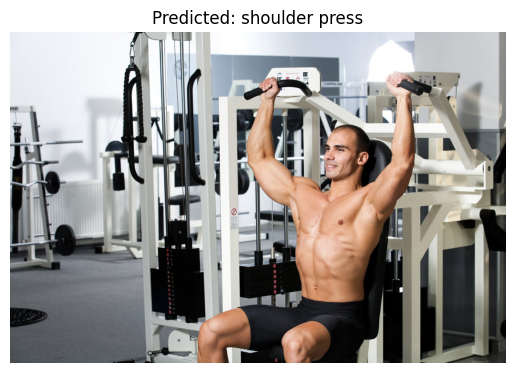

Predicted Exercise: shoulder press


In [ ]:
# Image URL to classify
image_url = "https://cdn.shopify.com/s/files/1/1876/4703/files/shutterstock_69079702_1024x1024.jpg?v=1644309689"  # Replace with an actual image URL

# Classify the image using the existing function
predicted_exercise = classify_image_from_url(image_url, model)
print(f"Predicted Exercise: {predicted_exercise}")

In [ ]:
import requests
import cv2
import mediapipe as mp
from PIL import Image
import io

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def download_and_extract_pose(image_url):
    """Downloads the image and extracts pose keypoints."""
    response = requests.get(image_url)
    if response.status_code != 200:
        raise ValueError(f"Failed to download image from {image_url}")

    # Convert image to OpenCV format
    image = Image.open(io.BytesIO(response.content))
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Convert to RGB for MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        # Extract normalized pose keypoints
        return extract_keypoints(results)
    else:
        print("No pose detected in image.")
        return None

# Extract pose keypoints from the new image
new_pose = download_and_extract_pose(image_url)


In [ ]:
def find_best_matching_pose(new_pose, exercise_label):
    """Finds the most similar pose in the dataset for the given exercise type."""
    best_match = None
    highest_similarity = -1

    # Ensure y_labels is a NumPy array
    global y_labels, X_dataset  # Ensure using global variables
    y_labels = np.array(y_labels)

    # Debugging: Print available labels
    if exercise_label not in y_labels:
        print(f"Exercise label '{exercise_label}' not found in dataset!")
        print("Available Labels:", np.unique(y_labels))

    # Ensure correct filtering
    relevant_indices = np.where(y_labels == exercise_label)[0]
    relevant_poses = X_dataset[relevant_indices] if len(relevant_indices) > 0 else X_dataset

    if len(relevant_poses) > 0:
        similarities = cosine_similarity([new_pose], relevant_poses)
        highest_similarity = np.max(similarities)
        best_match = relevant_poses[np.argmax(similarities)]
    else:
        highest_similarity = -1

    return highest_similarity

# Find similarity to dataset reference poses
if new_pose is not None:
    similarity_score = find_best_matching_pose(new_pose, predicted_exercise)
    print(f"📏 Pose Similarity Score: {similarity_score:.2f}")


📏 Pose Similarity Score: 0.40


In [ ]:
def assess_form(similarity_score, threshold=0.75):
    """Provides form assessment based on similarity to correct poses."""
    if similarity_score >= threshold:
        return "Form is correct!"
    elif 0.5 <= similarity_score < threshold:
        return "Form needs improvement."
    else:
        return "Incorrect form! Adjust your posture."

# Get form feedback
form_feedback = assess_form(similarity_score)
print("Form Feedback:", form_feedback)


Form Feedback: Incorrect form! Adjust your posture.
